# TFM - CCC ALGECIRAS 3 - ENERGY-PRICE CURVE PREDICTION


## 1. INTRODUCTION

In this Notebook a PREDICTED ENERGY-PRICE CURVE model will be created.

The following asumptions will be considered:

+ OMIE energy-price curves from November, 2019 to October, 2020 will be considered as the baseline data information. This info comes from the csv file "OMIE_PALOS1.csv", created previously in "TFM_merged-files.ipynb" notebook.


+ As the information in OMIE file does not consider all 12 blocks for every hourly curve, it is created a new dataframe with 12 blocks for all the curves.


+ Only the following information will be considered as features of the models (X):
    * Weekday
    * Period (hour)
    * Energy offered in the block 24h (one day) before the period considered (MWh)
    * Energy offered in the block 168h (one week) before the period considered (MWh)
   NOTE: In further stages of the project, total demanded energy and fuel gas price will be included as features as well. 
   
   
+ The following information will be considered as targets of the models (y):
    * Energy offered in the block (MWh)
    * Price (€/MWh)
    
    
+ The information from the original OMIE information will be split in the following way:
    * TRAIN SET: November, 2019 - August, 2020. (Note that November will have only 3 weeks, since there are no data for the energy offered one week before the first week of the month.)
    * VALIDATION SET: September, 2020
    * TEST SET: October, 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime, timedelta

from TFM_PredCurve_Tools import data_date_hour_info, convert_to_df_curve, days_25h_23h
from TFM_PredCurve_Tools import plot_bid_curve, plot_marginal_price
from TFM_PredCurve_Tools import plot_bid_curve_day, plot_marginal_price_day
from TFM_PredCurve_Tools import df_structure_24h, area_pred_curve_summary, df_pred_summary

In [2]:
#pd.reset_option('precision')
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
unit = 'ALGECIRAS3'

In [4]:
unit_pkl = unit + '_MargP'
path_pkl = '/home/dsc/Documents/TFM/Data/TFM_Pickle/'

## 2. RETRIEVING, EXPLORING AND PLOTTING OMIE DATA INFORMATION

### 2.1. RETRIEVING DATA INFORMATION

#### 2.1.1.  RETRIEVING DATA FROM BID CURVES

In [5]:
#df will be all data for unit PALOS1 from November 2019 to October 2020. 
#This data was previously created from OMIE web page in "TFM_merged-files.ipynb" notebook 
#and TFM_df_sel_unit_v0.ipynb.

df_unit = pd.read_csv('/home/dsc/Documents/TFM/Data/OMIE/OMIE_' + unit + '_112019_102020.csv',index_col=0)

In [179]:
df_unit.head()

,Bid_Code,Num_Version,Bid_Unit,Unit_Description,Sell_Buy,Pot_max,Year,Month,Day,Period,Block,Price,Energy
0,6132556,1,ALG3,C.C. ALGECIRAS 3,VNO,830.10,2020,1,4,1,1,61.30,410.30
1,6132556,1,ALG3,C.C. ALGECIRAS 3,VNO,830.10,2020,1,4,2,1,61.30,410.30
2,6132556,1,ALG3,C.C. ALGECIRAS 3,VNO,830.10,2020,1,4,3,1,61.30,410.30
3,6132556,1,ALG3,C.C. ALGECIRAS 3,VNO,830.10,2020,1,4,4,1,61.30,410.30
4,6132556,1,ALG3,C.C. ALGECIRAS 3,VNO,830.10,2020,1,4,5,1,61.30,410.30


In [7]:
df_unit.shape

(16305, 13)

In [8]:
df_unit.columns

Index(['Bid_Code', 'Num_Version', 'Bid_Unit', 'Unit_Description', 'Sell_Buy',
       'Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price',
       'Energy'],
      dtype='object')

In [9]:
df_unit.tail()

,Bid_Code,Num_Version,Bid_Unit,Unit_Description,Sell_Buy,Pot_max,Year,Month,Day,Period,Block,Price,Energy
16300,6126786,2,ALG3,C.C. ALGECIRAS 3,VNO,830.10,2019,12,31,22,2,127.30,20.30
16301,6126786,2,ALG3,C.C. ALGECIRAS 3,VNO,830.10,2019,12,31,23,1,0.01,390.00
16302,6126786,2,ALG3,C.C. ALGECIRAS 3,VNO,830.10,2019,12,31,23,2,127.30,20.30
16303,6126786,2,ALG3,C.C. ALGECIRAS 3,VNO,830.10,2019,12,31,24,1,0.01,390.00
16304,6126786,2,ALG3,C.C. ALGECIRAS 3,VNO,830.10,2019,12,31,24,2,127.30,20.30


In [10]:
df_unit.describe()

,Bid_Code,Num_Version,Pot_max,Year,Month,Day,Period,Block,Price,Energy
count,"16,305.00","16,305.00","16,305.00","16,305.00","16,305.00","16,305.00","16,305.00","16,305.00","16,305.00","16,305.00"
mean,"6,319,984.66",1.83,830.10,"2,019.92",6.05,15.54,13.19,1.65,46.78,356.56
std,"135,691.47",1.09,0.00,0.28,3.15,8.60,6.62,0.70,54.12,248.37
min,"6,051,653.00",0.00,830.10,"2,019.00",1.00,1.00,1.00,1.00,0.01,2.00
25%,"6,207,249.00",1.00,830.10,"2,020.00",3.00,8.00,8.00,1.00,0.01,145.00
50%,"6,320,966.00",2.00,830.10,"2,020.00",6.00,15.00,13.00,2.00,36.30,380.00
75%,"6,431,758.00",3.00,830.10,"2,020.00",9.00,23.00,19.00,2.00,64.30,450.10
max,"6,557,009.00",5.00,830.10,"2,020.00",12.00,31.00,25.00,4.00,180.30,830.10


In [11]:
df_unit.dtypes

Bid_Code              int64
Num_Version           int64
Bid_Unit             object
Unit_Description     object
Sell_Buy             object
Pot_max             float64
Year                  int64
Month                 int64
Day                   int64
Period                int64
Block                 int64
Price               float64
Energy              float64
dtype: object

In [12]:
#Converting df_unit to a df with only the information that will be needed for ploting the bid curve, including
#date and and weekday per each day, and including the total Energy for all blocks in a certain hour,
#(to be able to plot the bid curve)

df_curve = convert_to_df_curve(df_unit)

/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Date']= pd.to_datetime(df_curve[['Year', 'Month', 'Day']])
/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Weekday'] = df_curve['Date'].apply(lambda x: x.weekday())
/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [13]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,830.10,2019,11,1,1,1,0.01,390.00,2019-11-01,Friday,390.00
1,830.10,2019,11,1,1,2,72.30,440.10,2019-11-01,Friday,830.10
2,830.10,2019,11,1,2,1,0.01,390.00,2019-11-01,Friday,390.00
3,830.10,2019,11,1,2,2,72.30,440.10,2019-11-01,Friday,830.10
4,830.10,2019,11,1,3,1,0.01,390.00,2019-11-01,Friday,390.00


#### 2.1.2. RETRIEVING DATA FROM MARGINAL PRICE

In [14]:
df_marg_price = pd.read_csv('/home/dsc/Documents/TFM/Data/OMIE/MARGINAL_PRICES_SPAIN.csv',index_col=0)

In [15]:
df_marg_price.head()

,Year,Month,Day,Period,Marg_Price,Date
0,2019,1,1,1,66.88,2019-01-01
1,2019,1,1,2,66.88,2019-01-01
2,2019,1,1,3,66.00,2019-01-01
3,2019,1,1,4,63.64,2019-01-01
4,2019,1,1,5,58.85,2019-01-01


In [16]:
df_marg_price[(df_marg_price['Date']== str(df_curve['Date'].min())[0:10]) &
              (df_marg_price['Period']== df_marg_price['Period'].min())].index[0]

7296

In [17]:
df_marg_price[(df_marg_price['Date']== str(df_curve['Date'].max())[0:10]) &
              (df_marg_price['Period']== 24)].index[0]

16079

In [18]:
df_price = df_marg_price[df_marg_price[(df_marg_price['Date']== str(df_curve['Date'].min())[0:10]) &
              (df_marg_price['Period']== df_marg_price['Period'].min())].index[0]:
              df_marg_price[(df_marg_price['Date']== str(df_curve['Date'].max())[0:10]) &
              (df_marg_price['Period']== 24)].index[0]+1]

In [19]:
df_price.reset_index(drop=True,inplace=True)

In [20]:
df_price.describe()

,Year,Month,Day,Period,Marg_Price
count,"8,784.00","8,784.00","8,784.00","8,784.00","8,784.00"
mean,"2,019.83",6.51,15.76,12.50,33.28
std,0.37,3.45,8.81,6.92,11.45
min,"2,019.00",1.00,1.00,1.00,0.01
25%,"2,020.00",4.00,8.00,6.75,26.07
50%,"2,020.00",7.00,16.00,12.50,34.10
75%,"2,020.00",10.00,23.00,18.25,41.30
max,"2,020.00",12.00,31.00,25.00,65.64


In [21]:
df_price.head()

,Year,Month,Day,Period,Marg_Price,Date
0,2019,11,1,1,42.10,2019-11-01
1,2019,11,1,2,40.18,2019-11-01
2,2019,11,1,3,32.40,2019-11-01
3,2019,11,1,4,30.01,2019-11-01
4,2019,11,1,5,29.10,2019-11-01


In [22]:
df_price.tail()

,Year,Month,Day,Period,Marg_Price,Date
8779,2020,10,31,20,41.45,2020-10-31
8780,2020,10,31,21,44.83,2020-10-31
8781,2020,10,31,22,44.82,2020-10-31
8782,2020,10,31,23,40.90,2020-10-31
8783,2020,10,31,24,39.75,2020-10-31


In [23]:
df_price[['Year', 'Month', 'Day', 'Period','Marg_Price']].head()

,Year,Month,Day,Period,Marg_Price
0,2019,11,1,1,42.10
1,2019,11,1,2,40.18
2,2019,11,1,3,32.40
3,2019,11,1,4,30.01
4,2019,11,1,5,29.10


#### 2.1.3. MERGING DATAFRAMES

In [24]:
df_curve = df_curve.merge(df_price[['Year', 'Month', 'Day', 'Period','Marg_Price']], how = 'left')
df_curve

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price
0,830.10,2019,11,1,1,1,0.01,390.00,2019-11-01,Friday,390.00,42.10
1,830.10,2019,11,1,1,2,72.30,440.10,2019-11-01,Friday,830.10,42.10
2,830.10,2019,11,1,2,1,0.01,390.00,2019-11-01,Friday,390.00,40.18
3,830.10,2019,11,1,2,2,72.30,440.10,2019-11-01,Friday,830.10,40.18
4,830.10,2019,11,1,3,1,0.01,390.00,2019-11-01,Friday,390.00,32.40
...,...,...,...,...,...,...,...,...,...,...,...,...
16300,830.10,2020,10,31,22,2,58.30,460.10,2020-10-31,Saturday,830.10,44.82
16301,830.10,2020,10,31,23,1,0.01,370.00,2020-10-31,Saturday,370.00,40.90
16302,830.10,2020,10,31,23,2,58.30,460.10,2020-10-31,Saturday,830.10,40.90
16303,830.10,2020,10,31,24,1,0.01,370.00,2020-10-31,Saturday,370.00,39.75


In [25]:
df_curve.isnull().values.any()

False

In [26]:
df_curve.describe()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Energy_tot,Marg_Price
count,"16,305.00","16,305.00","16,305.00","16,305.00","16,305.00","16,305.00","16,305.00","16,305.00","16,305.00","16,305.00"
mean,830.10,"2,019.92",6.05,15.54,13.19,1.65,46.78,356.56,576.95,32.26
std,0.00,0.28,3.15,8.60,6.62,0.70,54.12,248.37,252.43,11.16
min,830.10,"2,019.00",1.00,1.00,1.00,1.00,0.01,2.00,20.00,0.01
25%,830.10,"2,020.00",3.00,8.00,8.00,1.00,0.01,145.00,380.00,25.31
50%,830.10,"2,020.00",6.00,15.00,13.00,2.00,36.30,380.00,680.00,33.07
75%,830.10,"2,020.00",9.00,23.00,19.00,2.00,64.30,450.10,830.10,40.13
max,830.10,"2,020.00",12.00,31.00,25.00,4.00,180.30,830.10,830.10,60.11


### 2.2. EXPLORING DATA INFORMATION

In [27]:
#Searching for NaN

if df_curve.shape[0] == df_curve.dropna().shape[0]:
    print('No NaN in df')

No NaN in df


In [28]:
data_date_hour_info(df_curve, '2020-10-31', 1)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price
16258,830.10,2020,10,31,1,1,58.30,830.10,2020-10-31,Saturday,830.10,35.04


In [29]:
data_date_hour_info(df_curve,'2020-10-31',24)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price
16303,830.10,2020,10,31,24,1,0.01,370.00,2020-10-31,Saturday,370.00,39.75
16304,830.10,2020,10,31,24,2,58.30,460.10,2020-10-31,Saturday,830.10,39.75


In [30]:
df_curve.shape

(16305, 12)

In [31]:
first_day = datetime(df_curve['Date'].min().year,
                  df_curve['Date'].min().month,
                  df_curve['Date'].min().day)

last_day = datetime(df_curve['Date'].max().year,
                  df_curve['Date'].max().month,
                  df_curve['Date'].max().day)

In [32]:
#Checking the number of years
num_years = len(df_curve['Year'].value_counts())
num_years

2

In [33]:
#Number of missing years in the original data

num_years_real = (last_day.year - first_day.year) + 1
diff_num_years = num_years_real - num_years
diff_num_years

0

In [34]:
#Checking the number of months in the original data

num_months = len(df_curve[['Year','Month']].value_counts())
num_months

12

In [35]:
#Number of missing months in the original data

num_months_real = (last_day.month -first_day.month) + 12*(last_day.year - first_day.year) + 1
diff_num_months = num_months_real - num_months
diff_num_months

0

In [36]:
#Checking the number of days in the original data

num_days = len(df_curve['Date'].value_counts())
num_days

322

In [37]:
df_curve['Date'].min()

Timestamp('2019-11-01 00:00:00')

In [38]:
df_curve['Date'].max()

Timestamp('2020-10-31 00:00:00')

In [39]:
num_days_real = (last_day - first_day).days + 1
num_days_real

366

In [40]:
#Number of missing days in original data
diff_num_days = num_days_real - num_days
diff_num_days

44

In [41]:
#Checking the number of hours in the original data

num_hours_real = num_days_real*24 #It should be checked if within the date range there is an odd number 
                                    #of 23h-day or 25-h-day
num_hours_real


8784

In [42]:
num_hours_orig_real = num_days*24 #It should be checked if within the date range there is an odd number 
                                    #of 23h-day or 25-h-day
num_hours_orig_real

7728

In [43]:
#Checking the number of hours

num_hours = df_curve.groupby(['Date','Period'])['Block'].count().value_counts().sum()
num_hours

7728

In [44]:
#Number of missing hours from the original data
diff_num_hours = num_hours_real - num_hours
diff_num_hours

1056

In [45]:
#Number of missing hours from the days in the original data
diff_num_hours_orig = num_hours_orig_real - num_hours
diff_num_hours_orig

0

In [46]:
(diff_num_hours_orig + diff_num_days*24) == diff_num_hours

True

In [47]:
#Number of hours per each block. We can see that the only block that appears in all periods is BLOCK 12.
df_curve.groupby(['Block'])['Period'].count()

Block
1    7728
2    6510
3    2039
4      28
Name: Period, dtype: int64

In [48]:
#Variable to include the number of the block that appears always (if there are more than one the minimum is chosen).

serie_block_all = df_curve.groupby(['Block'])['Period'].count()[df_curve.groupby(['Block'])['Period'].count() == num_hours]
serie_block_all = serie_block_all.reset_index()
block_all = serie_block_all['Block'].min()
block_all

1

In [49]:
#Variable to include the maximum number of blocks

block_max = df_curve['Block'].max()
block_max

4

In [50]:
#Checking that every day has 23, 24 or 25 hours
#We know that all periods have at least the block with the number equal to block_all

df_curve_hours = df_curve[(df_curve['Block']==block_all)].groupby('Date')['Period'].count()
df_curve_hours.value_counts()

24    320
25      1
23      1
Name: Period, dtype: int64

In [51]:
#Searching the days with 23h and 25h within the original data period. 
#It is known that in Spain times changes from 2am to 3am every last Sunday of March and 
#from 3am to 2am every last Sunday of October

days_25h, days_23h = days_25h_23h(df_curve)

In [52]:
days_25h, days_23h

([datetime.datetime(2020, 10, 25, 0, 0)],
 [datetime.datetime(2020, 3, 29, 0, 0)])

In [53]:
#View of some expamples of bids per hour

In [54]:
df_curve[(df_curve['Date']==days_25h[0])&(df_curve['Period'].isin([6,7,8]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price
15936,830.10,2020,10,25,6,1,73.30,830.10,2020-10-25,Sunday,830.10,1.95
15937,830.10,2020,10,25,7,1,73.30,830.10,2020-10-25,Sunday,830.10,1.95
15938,830.10,2020,10,25,8,1,0.01,40.00,2020-10-25,Sunday,40.00,1.95
15939,830.10,2020,10,25,8,2,73.30,790.10,2020-10-25,Sunday,830.10,1.95


### 2.3. PLOTTING DATA INFORMATION

In [55]:
sns.set_theme(style='darkgrid')

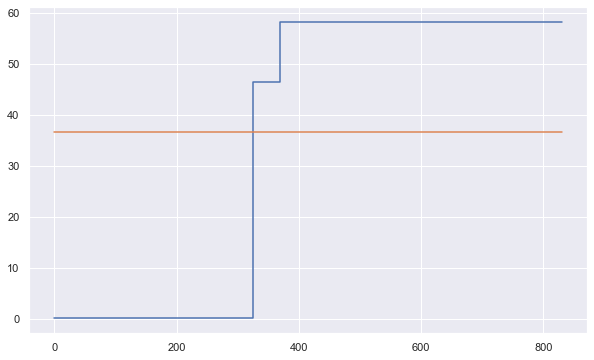

In [56]:
plt.figure().set_size_inches(10,6)
plot_bid_curve(df_curve, '2020-10-31', 11)
plot_marginal_price(df_curve, '2020-10-31', 11)

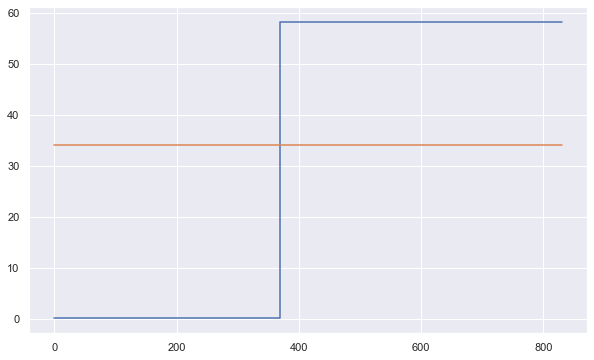

In [57]:
plt.figure().set_size_inches(10,6)
plot_bid_curve(df_curve, '2020-10-31', 12)
plot_marginal_price(df_curve, '2020-10-31', 12)

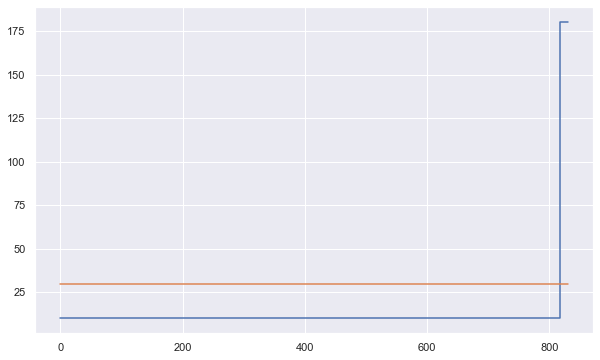

In [58]:
plt.figure().set_size_inches(10,6)
plot_bid_curve(df_curve, '2020-8-15', 13)
plot_marginal_price(df_curve, '2020-8-15', 13)

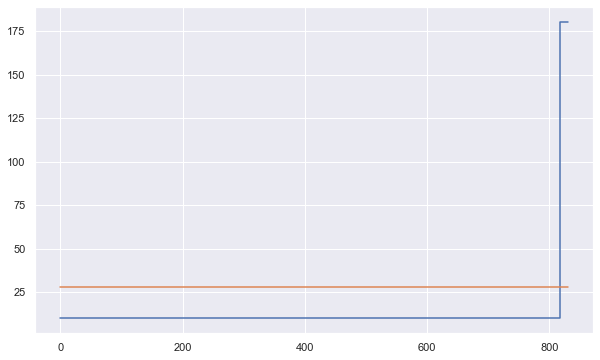

In [59]:
plt.figure().set_size_inches(10,6)
plot_bid_curve(df_curve, '2020-8-15', 14)
plot_marginal_price(df_curve, '2020-8-15', 14)

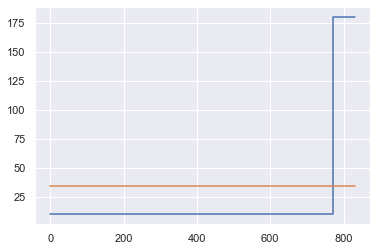

In [60]:
plot_bid_curve(df_curve, '2020-8-15', 24)
plot_marginal_price(df_curve, '2020-8-15', 24)

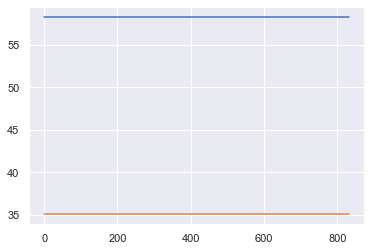

In [61]:
plot_bid_curve(df_curve,'2020-10-31', 1)
plot_marginal_price(df_curve,'2020-10-31', 1)

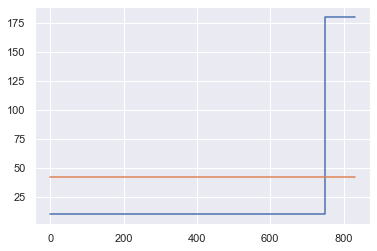

In [62]:
plot_bid_curve(df_curve,'2020-8-25', 1)
plot_marginal_price(df_curve,'2020-8-25', 1)

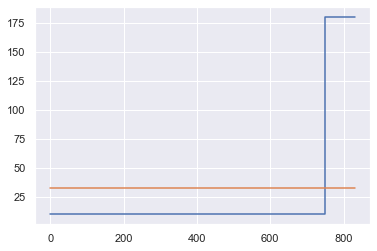

In [63]:
plot_bid_curve(df_curve,'2020-8-25',4)
plot_marginal_price(df_curve,'2020-8-25',4)

/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()
/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()


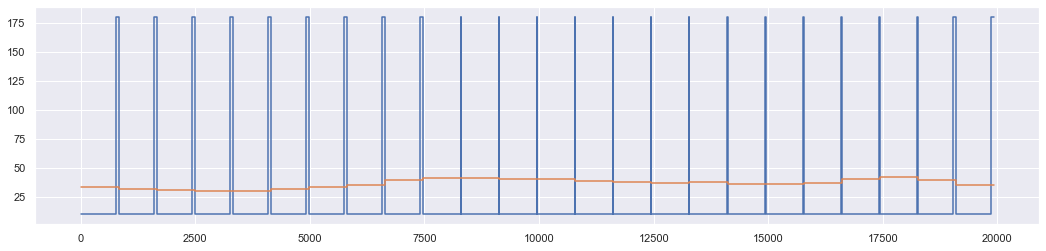

In [64]:
plt.figure().set_size_inches(18,4)
plot_bid_curve_day(df_curve,'2020-08-14')
plot_marginal_price_day(df_curve,'2020-08-14');

/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()
/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()


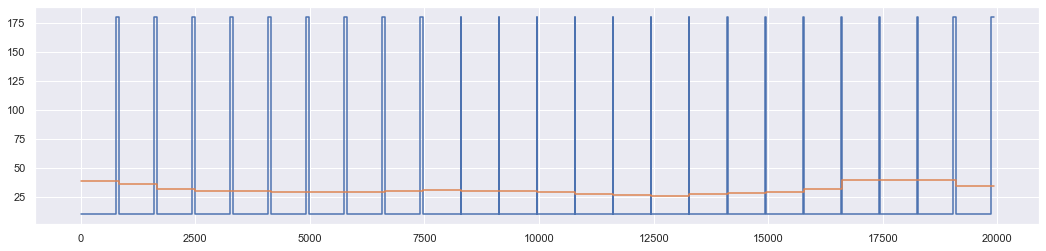

In [65]:
plt.figure().set_size_inches(18,4)
plot_bid_curve_day(df_curve,'2020-08-15')
plot_marginal_price_day(df_curve,'2020-08-15');

/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()
/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()


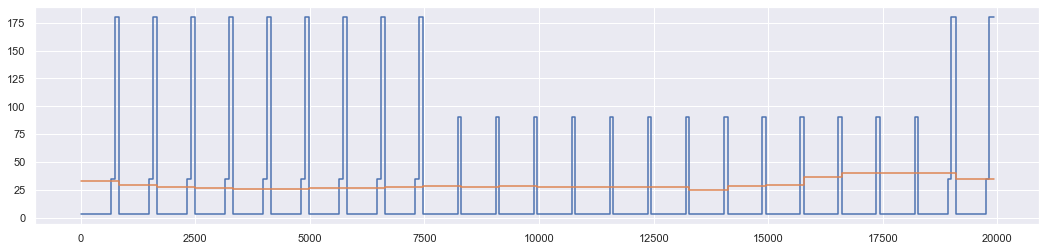

In [66]:
plt.figure().set_size_inches(18,4)
plot_bid_curve_day(df_curve,'2020-08-16')
plot_marginal_price_day(df_curve,'2020-08-16');

/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()
/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()


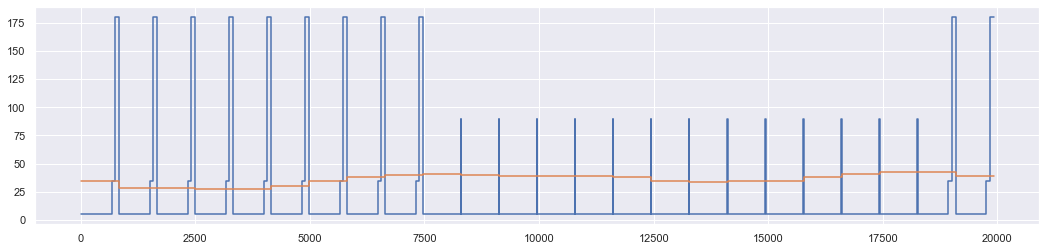

In [67]:
plt.figure().set_size_inches(18,4)
plot_bid_curve_day(df_curve,'2020-08-17')
plot_marginal_price_day(df_curve,'2020-08-17');

/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()
/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()


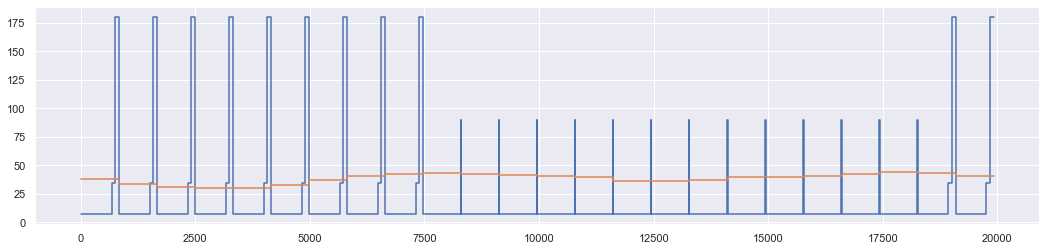

In [68]:
plt.figure().set_size_inches(18,4)
plot_bid_curve_day(df_curve,'2020-08-18')
plot_marginal_price_day(df_curve,'2020-08-18');

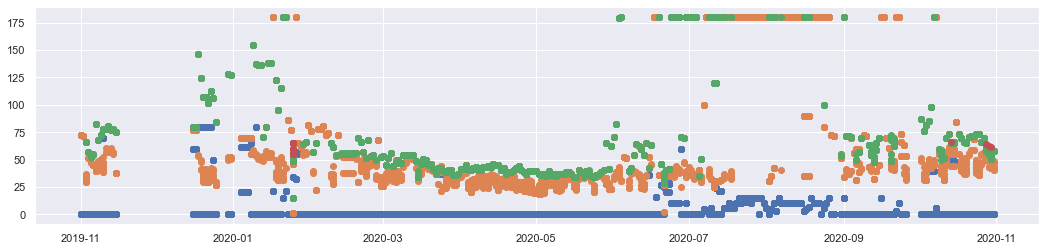

In [69]:
plt.figure().set_size_inches(18,4)
for block in range(1, df_curve['Block'].max()+1):
    plt.scatter(df_curve[df_curve['Block']==block]['Date'],df_curve[df_curve['Block']==block]['Price'])

#plt.scatter(df_price['Date'], df_price['Marg_Price'])

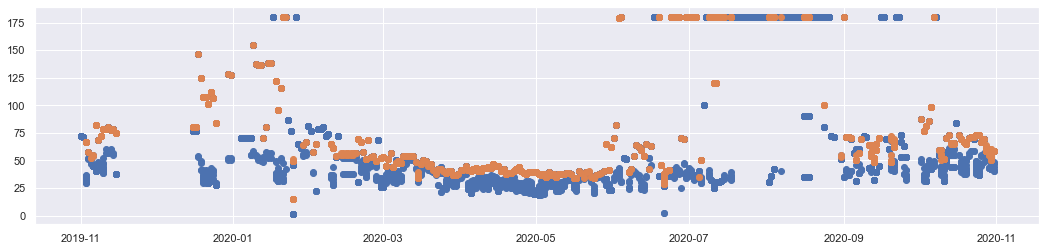

In [70]:
plt.figure().set_size_inches(18,4)

for block in range(2, df_curve['Block'].max()):
    plt.scatter(df_curve[df_curve['Block']==block]['Date'],df_curve[df_curve['Block']==block]['Price'])
    
    
#plt.scatter(df_price['Date'], df_price['Marg_Price'])

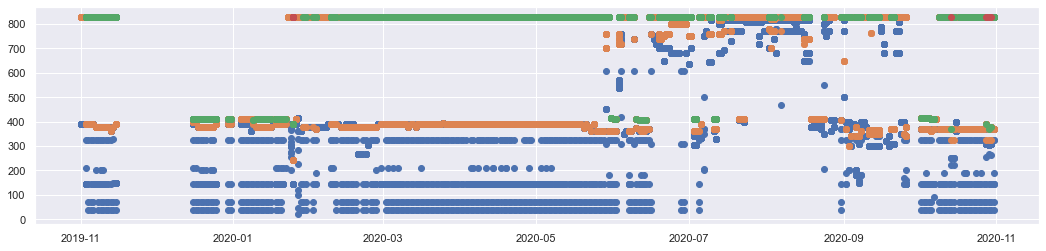

In [71]:
plt.figure().set_size_inches(18,4)

for block in range(1, df_curve['Block'].max()+1):
    plt.scatter(df_curve[df_curve['Block']==block]['Date'],df_curve[df_curve['Block']==block]['Energy_tot'])

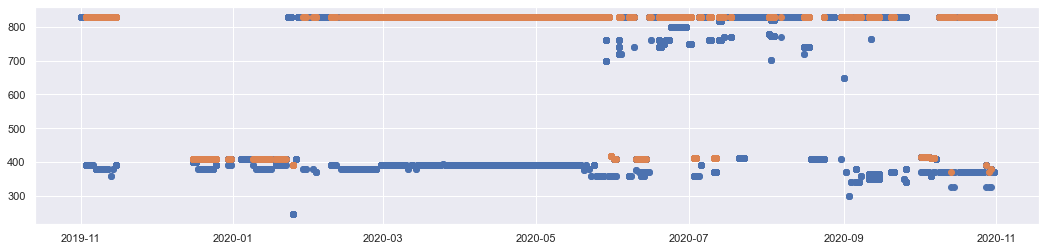

In [72]:
plt.figure().set_size_inches(18,4)

for block in range(2, df_curve['Block'].max()):
    plt.scatter(df_curve[df_curve['Block']==block]['Date'],df_curve[df_curve['Block']==block]['Energy_tot'])

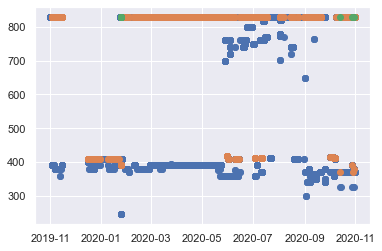

In [73]:
for block in range(2, 6):
    plt.scatter(df_curve[df_curve['Block']==block]['Date'],df_curve[df_curve['Block']==block]['Energy_tot'])

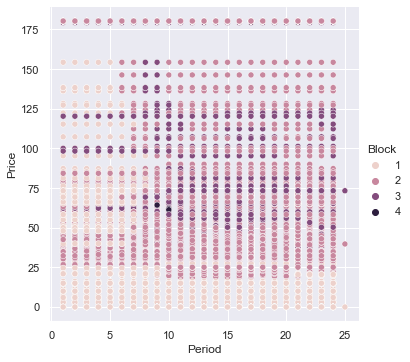

In [74]:
sns.relplot(data=df_curve, x='Period', y='Price', hue='Block')

In [75]:
#sns.relplot(data=df_curve, x='Period', y='Energy', hue='Block')

In [76]:
#sns.relplot(data=df_curve, x='Period', y='Energy_tot', hue='Block')

In [77]:
#sns.lineplot(data=df_price['Marg_Price']);

In [78]:
#sns.relplot(data=df_price, x='Date', y='Marg_Price', kind='line')

In [79]:
#sns.set(rc={'figure.figsize':(14, 4)})

#sns.relplot(data=df_curve[df_curve['Period']==23], x='Date', y='Marg_Price')

In [80]:
#sns.relplot(data=df_curve, x='Date', y='Price', hue='Block', kind='line')

In [81]:
#sns.relplot(data=df_curve[(df_curve['Block']!=1)&(df_curve['Block']!=12)], x='Date', y='Price', hue='Block', kind='line')

In [82]:
#sns.jointplot(data=df_curve, x='Period', y='Block')

In [83]:
#sns.jointplot(data=df_curve, x='Period', y='Price')

In [84]:
#sns.jointplot(data=df_curve, x='Period', y='Price', kind='kde')

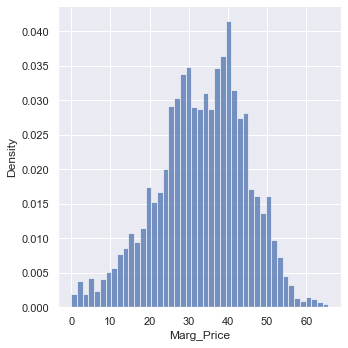

In [85]:
sns.displot(data=df_price, x='Marg_Price',stat='density')

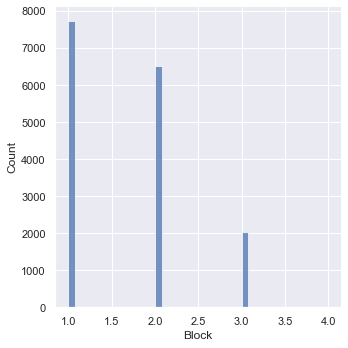

In [86]:
sns.displot(data=df_curve, x='Block',stat='count')

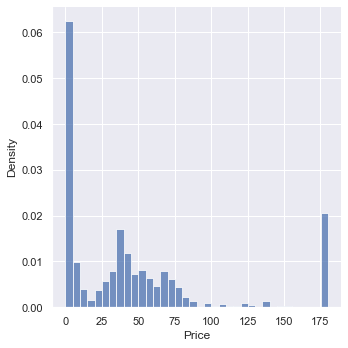

In [87]:
sns.displot(data=df_curve, x='Price',stat='density')

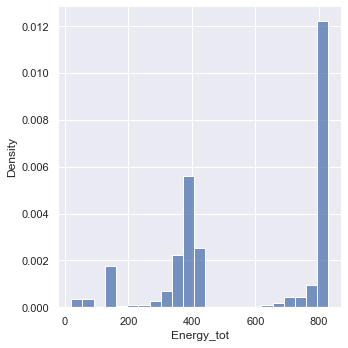

In [88]:
sns.displot(data=df_curve, x='Energy_tot',stat='density')

<AxesSubplot:xlabel='Block', ylabel='Price'>

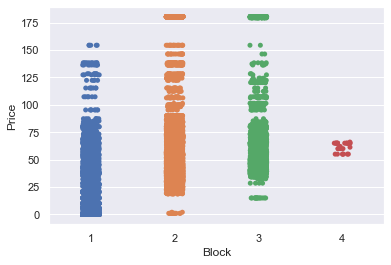

In [89]:
sns.stripplot(data=df_curve, x='Block', y='Price')

<AxesSubplot:xlabel='Weekday', ylabel='Price'>

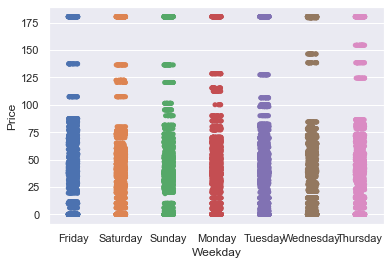

In [90]:
sns.stripplot(data=df_curve, x='Weekday', y='Price')

<AxesSubplot:xlabel='Weekday', ylabel='Energy_tot'>

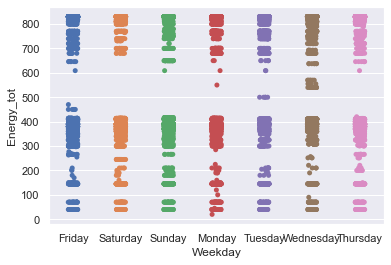

In [91]:
sns.stripplot(data=df_curve, x='Weekday', y='Energy_tot')

<AxesSubplot:xlabel='Period', ylabel='Price'>

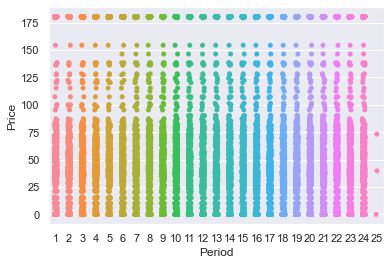

In [92]:
sns.stripplot(data=df_curve, x='Period', y='Price')

<AxesSubplot:xlabel='Period', ylabel='Price'>

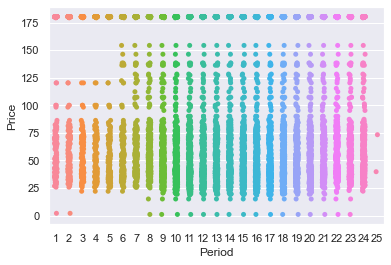

In [93]:
sns.stripplot(data=df_curve[(df_curve['Block']!=1)&(df_curve['Block']!=12)], x='Period', y='Price')

<AxesSubplot:xlabel='Period', ylabel='Energy_tot'>

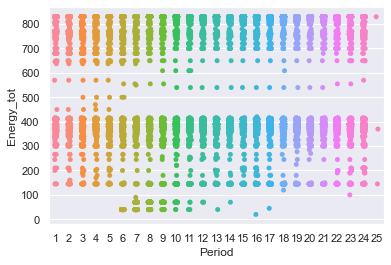

In [94]:
sns.stripplot(data=df_curve, x='Period', y='Energy_tot')

<AxesSubplot:xlabel='Period', ylabel='Energy_tot'>

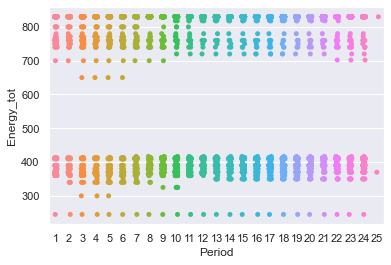

In [95]:
sns.stripplot(data=df_curve[(df_curve['Block']!=1)&(df_curve['Block']!=12)], x='Period', y='Energy_tot')

<AxesSubplot:xlabel='Period', ylabel='Price'>

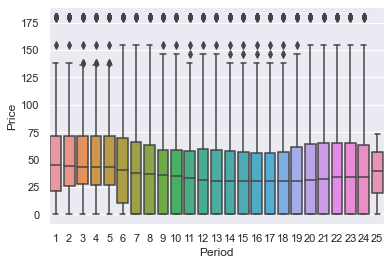

In [96]:
sns.boxplot(data=df_curve, x='Period', y='Price')

<AxesSubplot:xlabel='Block', ylabel='Price'>

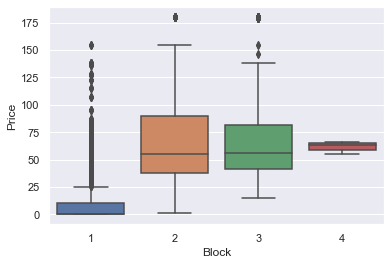

In [97]:
sns.boxplot(data=df_curve, x='Block', y='Price')

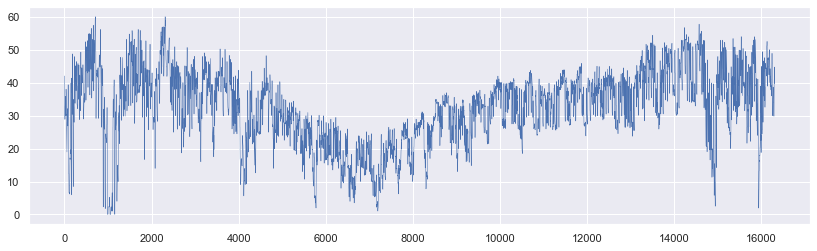

In [98]:
sns.set(rc={'figure.figsize':(14, 4)})
df_curve['Marg_Price'].plot(linewidth=0.5);

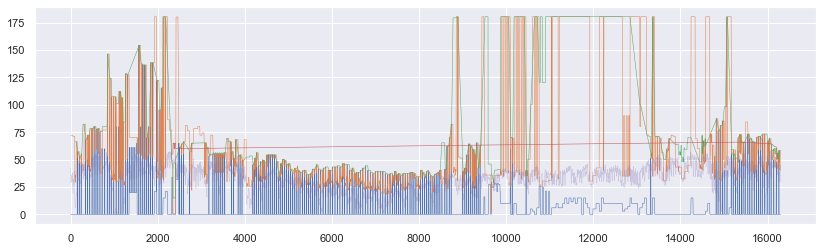

In [99]:
for block in range(1, df_curve['Block'].max()+1):
    df_curve[df_curve['Block']==block]['Price'].plot(linewidth=0.5)

df_curve['Marg_Price'].plot(linewidth=0.5,alpha=.3);

## 3. DATA WRANGLING

### 3.1. CREATING A NEW DATAFRAME CONVERTING ALL DAYS INTO 24h-DAYS

First of all a new dataframe is created considering that all days have 24h. In order to do it, it is deleted...

In [100]:
#New dataframe is created considering 24h for all days
df_curve_24h = df_curve.copy()

In [101]:
#Funtions needed for renaming periods in 23h-days and 25h-days.

def change_25h_to24h(x):
    if x >= 4:
        x -= 1
    return x

def change_23h_to24h(x):
    if x >= 2:
        x += 1
    return x

In [102]:
#Transforming 25h-day into 24h-day.

for date_25h in days_25h:
    #dataframe only with 25h-day data
    df_curve_day25h = df_curve_24h[df_curve_24h['Date']==date_25h]
    #Deleting period 3 from 25h-days.
    df_curve_day25h = df_curve_day25h.drop(df_curve_day25h.loc[df_curve_day25h['Period']==3].index)
    #Renaming periods from 4 to 25 to 3 to 24
    df_curve_day25h['Period'] = df_curve_day25h['Period'].apply(change_25h_to24h)
    df_curve_24h = df_curve_24h.drop(df_curve_24h[df_curve_24h['Date']==date_25h].index)
    df_curve_24h = pd.concat([df_curve_24h,df_curve_day25h])

In [103]:
#Transforming 23h-day into 24h-day.

for date_23h in days_23h:
    df_curve_day23h = df_curve_24h[df_curve_24h['Date']==date_23h]
    #Renaming periods from 2 to 23 to 3 to 24
    df_curve_day23h['Period'] = df_curve_day23h['Period'].apply(change_23h_to24h)
    #Copying period 1 as period 2 and renaming it
    df_curve_day23h_period1 = df_curve_day23h[(df_curve_day23h['Date']==date_23h)&(df_curve_day23h['Period']==1)]
    df_curve_day23h_period1['Period'] = df_curve_day23h_period1['Period'].apply(lambda x: x+1)
    df_curve_day23h = df_curve_day23h.append(df_curve_day23h_period1, ignore_index=True)
    df_curve_24h = df_curve_24h.drop(df_curve_24h[df_curve_24h['Date']==date_23h].index)
    df_curve_24h = pd.concat([df_curve_24h,df_curve_day23h])

<ipython-input-103-377225477582>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve_day23h['Period'] = df_curve_day23h['Period'].apply(change_23h_to24h)
<ipython-input-103-377225477582>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve_day23h_period1['Period'] = df_curve_day23h_period1['Period'].apply(lambda x: x+1)


In [104]:
df_curve_24h = df_curve_24h.sort_values(['Date','Period','Block']).reset_index(drop=True)

In [105]:
df_curve_24h.shape, df_curve.shape

((16305, 12), (16305, 12))


### 3.2. CREATING A NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR 

In this section a new dataframe will be created from the original one (with only 24h-days) by completing the information por every hour that does not have all blocks (12). 

It is important to point out that in the original dataframe does not have 12 blocks per each hour (or period), since not always is necessary in the biding curve. In order to use the information in the models that will be created, it is important that every hour is divided in 12 blocks. 

As the original dataframe does not have all days and hours for a given period, it is decided to create a new dataframe equal to the original one (only for dates, hours and blocks) but with all 12 blocks per each hour in the orignal data.

The new dataframe is created considering a df structure for 1 Block and then copy this new df, changing the number of the block and appending it to the original. The correct structure of the df will be created by doing it 12 times.

Then this new dataframe will be merged with the original one so NaN will be created for all the columns without blocks in the original dataframe. This NaN will be filled depending on each case.

#### 3.2.1. CREATING AN EMPTY DATAFRAME WITH THE SAME STRUCTRUE AS THE ORIGINAL WITH 24h-DAYS AND ALL BLOCKS PER EACH HOUR

In [106]:
#Checking blocks for one day
data_date_hour_info(df_curve, '2020-10-22',9)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price
15798,830.10,2020,10,22,9,1,0.01,145.00,2020-10-22,Thursday,145.00,49.53
15799,830.10,2020,10,22,9,2,58.88,225.00,2020-10-22,Thursday,370.00,49.53
15800,830.10,2020,10,22,9,3,71.30,460.10,2020-10-22,Thursday,830.10,49.53


In [107]:
#Creating a new df with the same structure of the orinal one, without 23h and 25h-days. 
#First of all, it is choosen from the orininal df the information from the date, hours and ONE block.
#Block number "block_all" is choosen as it is the only block that it is in all the hour.

df_block_24h = df_curve_24h[['Year','Month','Day','Period','Block']][df_curve_24h['Block']==block_all].reset_index(drop=True)

#Changing the value of all Blocks to 1
df_block_24h['Block'] = 1

#Creating a new dataframe with the same structure for all Blocks
df_block_tot_24h = pd.DataFrame()

for block_24h in range(1,block_max+1):
    df_block_new_24h = df_block_24h.copy()
    df_block_new_24h['Block'] = block_24h
    df_block_tot_24h = pd.concat([df_block_tot_24h,df_block_new_24h])
    

df_block_tot_24h.reset_index(inplace=True,drop=True)

In [108]:
len(df_block_tot_24h) == df_block_24h.shape[0]*block_max

True

In [109]:
df_block_tot_24h.shape

(30912, 5)

#### 3.2.2. CREATING AN NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR (without 23h and 25h-days)

In [110]:
#Now the complete dataframe is created by merging the original df (df_curve) with the new structure dataframe 
#created (df_block_tot)

df_tot_24h = df_curve_24h.merge(df_block_tot_24h,how='outer')

#New dataframe is sorted and reseted index
df_tot_24h = df_tot_24h.sort_values(['Year','Month','Day','Period','Block']).reset_index(drop=True)

#As the structrue dataframe has more rows that the original, a lot of NaN have been created.
#These NaN must be filled.

#As Block 1 is always in the original dataframe and dataframe is sorted by 'Block', bfill is the
#right method to fill NaN since the meaning of no Block in OMIE curve is a fixed Price.
df_tot_24h['Price'].fillna(method='ffill',inplace=True)

#Pot_max is allways the same value
df_tot_24h['Pot_max'].fillna(df_tot_24h['Pot_max'].max(),inplace=True)

#For the same reason of Price, Weekday is filled with bfill method
df_tot_24h['Weekday'].fillna(method='ffill',inplace=True)

#For the same reason of Price, Datw is filled with bfill method
df_tot_24h['Date'].fillna(method='ffill',inplace=True)

#Energy NaN will be filled with 0 since allways Energy of Block 1 must be Pot_max
df_tot_24h['Energy'].fillna(float(0),inplace=True)

#For the same reason of Price, Energy_tot is filled with bfill method
df_tot_24h['Energy_tot'].fillna(method='ffill',inplace=True)

#NaN in Marg_Price will be filled with bfill method 
df_tot_24h['Marg_Price'].fillna(method='ffill',inplace=True)

In [111]:
df_tot_24h

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price
0,830.10,2019,11,1,1,1,0.01,390.00,2019-11-01,Friday,390.00,42.10
1,830.10,2019,11,1,1,2,72.30,440.10,2019-11-01,Friday,830.10,42.10
2,830.10,2019,11,1,1,3,72.30,0.00,2019-11-01,Friday,830.10,42.10
3,830.10,2019,11,1,1,4,72.30,0.00,2019-11-01,Friday,830.10,42.10
4,830.10,2019,11,1,2,1,0.01,390.00,2019-11-01,Friday,390.00,40.18
...,...,...,...,...,...,...,...,...,...,...,...,...
30907,830.10,2020,10,31,23,4,58.30,0.00,2020-10-31,Saturday,830.10,40.90
30908,830.10,2020,10,31,24,1,0.01,370.00,2020-10-31,Saturday,370.00,39.75
30909,830.10,2020,10,31,24,2,58.30,460.10,2020-10-31,Saturday,830.10,39.75
30910,830.10,2020,10,31,24,3,58.30,0.00,2020-10-31,Saturday,830.10,39.75


In [112]:
#Searching for NaN

if df_tot_24h.shape[0] == df_tot_24h.dropna().shape[0]:
    print('No NaN in df')

No NaN in df


In [113]:
df_tot_24h.shape

(30912, 12)

In [114]:
#df_tot_24h.to_csv('/home/dsc/Repos/TFM/df_tot_24h_PALOS1.csv')

### 3.3. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD (without 23h and 25h-days)

In order to create a proper dataframe used in the models it is important to consider the data from previous bids, so a dataframe with the Energy and Price with a time lag of 24h and 168h is created. The best way to do it is to shift the columns Energy and Price 24x12 and 168x12 down, but this only works if all the dates, hours, and blocks are in the the dataframe. As it is not the case, a new dataframe should be created with NaN in the places where the dates and hours are missing in the original dataframe.

#### 3.3.1. CREATING AN EMPTY DATA STRUCTURE GIVEN A STARTING AND ENDING DATES  (without 23h & 25h-days)

In [115]:
struct_block_24h = df_structure_24h(df_tot_24h['Date'].min().year,
                              df_tot_24h['Date'].min().month,
                              df_tot_24h['Date'].min().day,
                              df_tot_24h['Date'].max().year,
                              df_tot_24h['Date'].max().month,
                              df_tot_24h['Date'].max().day,
                              block_max) 

In [116]:
struct_block_24h

,Date,Year,Month,Day,Period,Block
0,2019-11-01,2019,11,1,1,1
1,2019-11-01,2019,11,1,1,2
2,2019-11-01,2019,11,1,1,3
3,2019-11-01,2019,11,1,1,4
4,2019-11-01,2019,11,1,2,1
...,...,...,...,...,...,...
35131,2020-10-31,2020,10,31,23,4
35132,2020-10-31,2020,10,31,24,1
35133,2020-10-31,2020,10,31,24,2
35134,2020-10-31,2020,10,31,24,3


#### 3.3.2. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD (without 23h &25h-days)

In [117]:
df_tot_24h.shape, struct_block_24h.shape

((30912, 12), (35136, 6))

In [118]:
#Now the complete dataframe is created by merging the complete-block df (df_tot) with the new structure dataframe 
#created (structure_block)

df_tot_struct_24h = df_tot_24h.merge(struct_block_24h,how='outer')
df_tot_struct_24h = df_tot_struct_24h.sort_values(['Date','Period','Block']).reset_index(drop=True)

In [119]:
df_tot_24h.shape, struct_block_24h.shape, df_tot_struct_24h.shape

((30912, 12), (35136, 6), (35136, 12))

## PLOTING WITH NEW df_tot_struct_24h

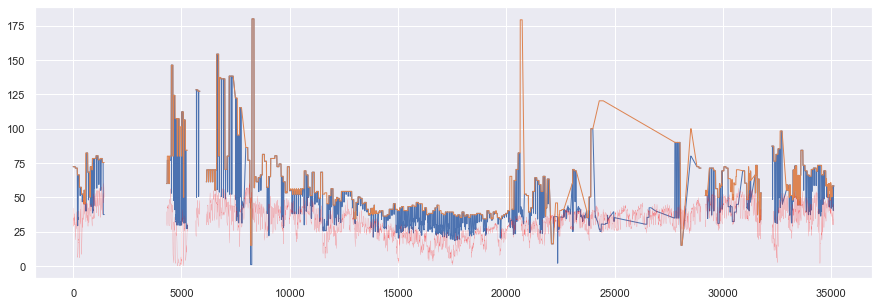

In [120]:
sns.set(rc={'figure.figsize':(15, 5)})

for block in range(2, df_tot_struct_24h['Block'].max()):
    df_tot_struct_24h[(df_tot_struct_24h['Block']==block)&
                      (df_tot_struct_24h['Price']!=df_tot_struct_24h['Price'].max())]['Price'].plot(linewidth=1)

df_tot_struct_24h[df_tot_struct_24h['Block']==1]['Marg_Price'].plot(linewidth=0.2,alpha=.5,color='red');

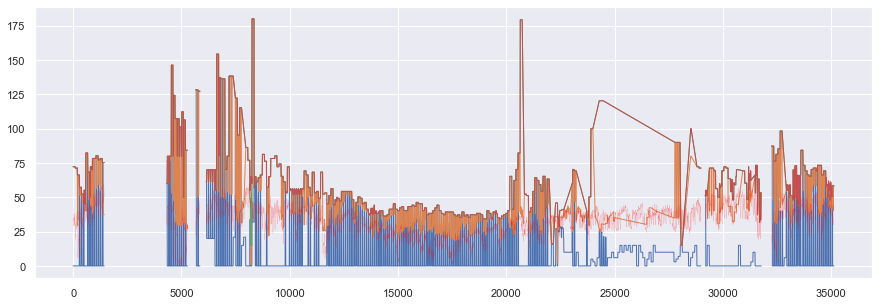

In [121]:
sns.set(rc={'figure.figsize':(15, 5)})

for block in range(1, df_tot_struct_24h['Block'].max()+1):
    df_tot_struct_24h[(df_tot_struct_24h['Block']==block)&
                      (df_tot_struct_24h['Price']!=df_tot_struct_24h['Price'].max())]['Price'].plot(linewidth=1)

df_tot_struct_24h[df_tot_struct_24h['Block']==1]['Marg_Price'].plot(linewidth=0.2,alpha=.5,color='red');

In [122]:
df_tot_struct_24h[(df_tot_struct_24h['Price']-df_tot_struct_24h['Marg_Price'])<=0]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price
0,830.10,2019,11,1,1,1,0.01,390.00,2019-11-01,Friday,390.00,42.10
4,830.10,2019,11,1,2,1,0.01,390.00,2019-11-01,Friday,390.00,40.18
8,830.10,2019,11,1,3,1,0.01,390.00,2019-11-01,Friday,390.00,32.40
12,830.10,2019,11,1,4,1,0.01,390.00,2019-11-01,Friday,390.00,30.01
16,830.10,2019,11,1,5,1,0.01,390.00,2019-11-01,Friday,390.00,29.10
...,...,...,...,...,...,...,...,...,...,...,...,...
35116,830.10,2020,10,31,20,1,0.01,370.00,2020-10-31,Saturday,370.00,41.45
35120,830.10,2020,10,31,21,1,0.01,370.00,2020-10-31,Saturday,370.00,44.83
35124,830.10,2020,10,31,22,1,0.01,370.00,2020-10-31,Saturday,370.00,44.82
35128,830.10,2020,10,31,23,1,0.01,370.00,2020-10-31,Saturday,370.00,40.90


In [123]:
df_tot_struct_24h[(df_tot_struct_24h['Price']-df_tot_struct_24h['Marg_Price'])<=0].groupby(['Date','Period'])['Price'].max()

Date        Period
2019-11-01  1        0.01
            2        0.01
            3        0.01
            4        0.01
            5        0.01
                     ... 
2020-10-31  20       0.01
            21       0.01
            22       0.01
            23       0.01
            24       0.01
Name: Price, Length: 6501, dtype: float64

### 3.4. CREATING AN NEW DATAFRAME WITH PRICE AND ENERGY TIME-LAGGED

In [124]:
df_tot_lagT = df_tot_struct_24h.copy()

In [125]:
df_tot_lagT.shape

(35136, 12)

In [126]:
time_lag1 = 24 #One day in hours
time_lag2 = 24*7 #One week in hours
num_blocks = block_max #Number of blocks per each hour

df_tot_lagT['Energy_24h'] = df_tot_lagT['Energy'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Energy_168h'] = df_tot_lagT['Energy'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Price_24h'] = df_tot_lagT['Price'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Price_168h'] = df_tot_lagT['Price'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Energy_tot_24h'] = df_tot_lagT['Energy_tot'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Energy_tot_168h'] = df_tot_lagT['Energy_tot'].shift(periods=time_lag2*num_blocks)

df_tot_lagT['Marg_Price_24h'] = df_tot_lagT['Marg_Price'].shift(periods=time_lag1*num_blocks)

#Just for checking purposes
df_tot_lagT['Date_24h'] = df_tot_lagT['Date'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Period_24h'] = df_tot_lagT['Period'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Block_24h'] = df_tot_lagT['Block'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Date_168h'] = df_tot_lagT['Date'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Period_168h'] = df_tot_lagT['Period'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Block_168h'] = df_tot_lagT['Block'].shift(periods=time_lag2*num_blocks)

In [127]:
#Checking that the shift operation has been done OK

df_tot_lagT_checking = df_tot_lagT.copy()

df_tot_lagT_checking['Date_OK'] = df_tot_lagT_checking['Date'] - df_tot_lagT_checking['Date_24h']
df_tot_lagT_checking['Date_168h_OK'] = df_tot_lagT_checking['Date'] - df_tot_lagT_checking['Date_168h']
df_tot_lagT_checking['Period_OK'] = df_tot_lagT_checking['Period'] - df_tot_lagT_checking['Period_24h']
df_tot_lagT_checking['Period_168h_OK'] = df_tot_lagT_checking['Period'] - df_tot_lagT_checking['Period_168h']
df_tot_lagT_checking['Block_OK'] = df_tot_lagT_checking['Block'] - df_tot_lagT_checking['Block_24h']
df_tot_lagT_checking['Block_168h_OK'] = df_tot_lagT_checking['Block'] - df_tot_lagT_checking['Block_168h']

In [128]:
df_tot_lagT_checking[['Date_OK','Date_168h_OK','Period_OK','Period_168h_OK','Block_OK','Block_168h_OK']].describe()

,Date_OK,Date_168h_OK,Period_OK,Period_168h_OK,Block_OK,Block_168h_OK
count,35040,34464,"35,040.00","34,464.00","35,040.00","34,464.00"
mean,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
std,0 days 00:00:00,0 days 00:00:00,0.00,0.00,0.00,0.00
min,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
25%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
50%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
75%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
max,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00


In [129]:
#Everthing is OK since date date time interval is 1 day and 7 days and period, and blocks are the same for all
#of the rows

In [130]:
df_tot_lagT.columns

Index(['Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price', 'Energy',
       'Date', 'Weekday', 'Energy_tot', 'Marg_Price', 'Energy_24h',
       'Energy_168h', 'Price_24h', 'Price_168h', 'Energy_tot_24h',
       'Energy_tot_168h', 'Marg_Price_24h', 'Date_24h', 'Period_24h',
       'Block_24h', 'Date_168h', 'Period_168h', 'Block_168h'],
      dtype='object')

In [131]:
#Picking the correct columns
columns = ['Year', 'Month', 'Day', 'Period', 'Block', 'Date', 'Weekday',
           'Energy', 'Energy_tot','Price', 'Energy_24h', 'Energy_tot_24h', 'Price_24h', 
           'Energy_168h', 'Energy_tot_168h', 'Price_168h', 'Marg_Price', 'Marg_Price_24h','Pot_max']

In [132]:
df_tot_lagT = df_tot_lagT[columns]

In [133]:
df_tot_lagT.head()

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Marg_Price,Marg_Price_24h,Pot_max
0,2019,11,1,1,1,2019-11-01,Friday,390.00,390.00,0.01,nan,nan,nan,nan,nan,nan,42.10,nan,830.10
1,2019,11,1,1,2,2019-11-01,Friday,440.10,830.10,72.30,nan,nan,nan,nan,nan,nan,42.10,nan,830.10
2,2019,11,1,1,3,2019-11-01,Friday,0.00,830.10,72.30,nan,nan,nan,nan,nan,nan,42.10,nan,830.10
3,2019,11,1,1,4,2019-11-01,Friday,0.00,830.10,72.30,nan,nan,nan,nan,nan,nan,42.10,nan,830.10
4,2019,11,1,2,1,2019-11-01,Friday,390.00,390.00,0.01,nan,nan,nan,nan,nan,nan,40.18,nan,830.10


In [134]:
df_tot_lagT.shape

(35136, 19)

In [135]:
#Dropping all rows with NaN, since there are not enought data to build a dataframe (due to time lagging and 
#lack of data from the original dataframe

df_tot_lagT.dropna(inplace=True)
df_tot_lagT.head()

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Marg_Price,Marg_Price_24h,Pot_max
672,2019,11,8,1,1,2019-11-08,Friday,830.10,830.10,68.30,200.00,200.00,0.01,390.00,390.00,0.01,36.94,39.07,830.10
673,2019,11,8,1,2,2019-11-08,Friday,0.00,830.10,68.30,180.00,380.00,42.30,440.10,830.10,72.30,36.94,39.07,830.10
674,2019,11,8,1,3,2019-11-08,Friday,0.00,830.10,68.30,450.10,830.10,82.30,0.00,830.10,72.30,36.94,39.07,830.10
675,2019,11,8,1,4,2019-11-08,Friday,0.00,830.10,68.30,0.00,830.10,82.30,0.00,830.10,72.30,36.94,39.07,830.10
676,2019,11,8,2,1,2019-11-08,Friday,830.10,830.10,68.30,145.00,145.00,0.01,390.00,390.00,0.01,30.21,35.95,830.10


In [136]:
df_tot_lagT = df_tot_lagT.sort_values(['Year', 'Month', 'Day', 'Period', 'Block'])
df_tot_lagT

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Marg_Price,Marg_Price_24h,Pot_max
672,2019,11,8,1,1,2019-11-08,Friday,830.10,830.10,68.30,200.00,200.00,0.01,390.00,390.00,0.01,36.94,39.07,830.10
673,2019,11,8,1,2,2019-11-08,Friday,0.00,830.10,68.30,180.00,380.00,42.30,440.10,830.10,72.30,36.94,39.07,830.10
674,2019,11,8,1,3,2019-11-08,Friday,0.00,830.10,68.30,450.10,830.10,82.30,0.00,830.10,72.30,36.94,39.07,830.10
675,2019,11,8,1,4,2019-11-08,Friday,0.00,830.10,68.30,0.00,830.10,82.30,0.00,830.10,72.30,36.94,39.07,830.10
676,2019,11,8,2,1,2019-11-08,Friday,830.10,830.10,68.30,145.00,145.00,0.01,390.00,390.00,0.01,30.21,35.95,830.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,2020,10,31,23,4,2020-10-31,Saturday,0.00,830.10,58.30,0.00,830.10,50.30,0.00,830.10,73.30,40.90,43.09,830.10
35132,2020,10,31,24,1,2020-10-31,Saturday,370.00,370.00,0.01,307.80,307.80,0.01,145.00,145.00,0.01,39.75,42.41,830.10
35133,2020,10,31,24,2,2020-10-31,Saturday,460.10,830.10,58.30,72.20,380.00,43.00,225.00,370.00,39.74,39.75,42.41,830.10
35134,2020,10,31,24,3,2020-10-31,Saturday,0.00,830.10,58.30,450.10,830.10,50.30,460.10,830.10,73.30,39.75,42.41,830.10


In [137]:
df_tot_lagT.reset_index(drop=True, inplace=True)
df_tot_lagT

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Marg_Price,Marg_Price_24h,Pot_max
0,2019,11,8,1,1,2019-11-08,Friday,830.10,830.10,68.30,200.00,200.00,0.01,390.00,390.00,0.01,36.94,39.07,830.10
1,2019,11,8,1,2,2019-11-08,Friday,0.00,830.10,68.30,180.00,380.00,42.30,440.10,830.10,72.30,36.94,39.07,830.10
2,2019,11,8,1,3,2019-11-08,Friday,0.00,830.10,68.30,450.10,830.10,82.30,0.00,830.10,72.30,36.94,39.07,830.10
3,2019,11,8,1,4,2019-11-08,Friday,0.00,830.10,68.30,0.00,830.10,82.30,0.00,830.10,72.30,36.94,39.07,830.10
4,2019,11,8,2,1,2019-11-08,Friday,830.10,830.10,68.30,145.00,145.00,0.01,390.00,390.00,0.01,30.21,35.95,830.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28123,2020,10,31,23,4,2020-10-31,Saturday,0.00,830.10,58.30,0.00,830.10,50.30,0.00,830.10,73.30,40.90,43.09,830.10
28124,2020,10,31,24,1,2020-10-31,Saturday,370.00,370.00,0.01,307.80,307.80,0.01,145.00,145.00,0.01,39.75,42.41,830.10
28125,2020,10,31,24,2,2020-10-31,Saturday,460.10,830.10,58.30,72.20,380.00,43.00,225.00,370.00,39.74,39.75,42.41,830.10
28126,2020,10,31,24,3,2020-10-31,Saturday,0.00,830.10,58.30,450.10,830.10,50.30,460.10,830.10,73.30,39.75,42.41,830.10


In [138]:
#Searching for NaN

if df_tot_lagT.shape[0] == df_tot_lagT.dropna().shape[0]:
    print('No NaN in df')

No NaN in df


In [139]:
df_tot_lagT.head()

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Marg_Price,Marg_Price_24h,Pot_max
0,2019,11,8,1,1,2019-11-08,Friday,830.10,830.10,68.30,200.00,200.00,0.01,390.00,390.00,0.01,36.94,39.07,830.10
1,2019,11,8,1,2,2019-11-08,Friday,0.00,830.10,68.30,180.00,380.00,42.30,440.10,830.10,72.30,36.94,39.07,830.10
2,2019,11,8,1,3,2019-11-08,Friday,0.00,830.10,68.30,450.10,830.10,82.30,0.00,830.10,72.30,36.94,39.07,830.10
3,2019,11,8,1,4,2019-11-08,Friday,0.00,830.10,68.30,0.00,830.10,82.30,0.00,830.10,72.30,36.94,39.07,830.10
4,2019,11,8,2,1,2019-11-08,Friday,830.10,830.10,68.30,145.00,145.00,0.01,390.00,390.00,0.01,30.21,35.95,830.10


In [140]:
df_tot_lagT.shape[0]/4

7032.0

In [141]:
(df_tot_lagT['Date'].max() - df_tot_lagT['Date'].min()).days + 1

359

### 3.5. CREATING DATAFRAMES AS MODELS' INPUT


### 3.5.1. BUILDING DATAFRAMES PER PERIOD (HOUR) - DELTA ENERGY APPROACH

In this section models' input dataframes will be created, considering that the models will be built for each period (hour). 

First of all, the following features will be considered for X:

* Weekday
* Block
* Energy 24h lagged
* Energy 168h lagged
* Price 24h lagged
* Price 168h lagged
* Marginal Price 24h lagged

The target variables (y) will be:

* Energy
* Price

Note that Delta Energy will be considered as Energy. It is considered that this approach will work better than considering Energy as target instead of Energy_tot.

Dataframes will be splitted in the following way:

* TRAIN SET: data set to train the models
* VALIDATION SET: data set to validate and to select the models' hyperparamenters
* TEST SET: data set to test the models

The sppliting will be done considering the following time preriods:

* TEST SET: last month of the data set --> 2020-10-01 to 2020-10-31
* VALIDATION SET: before last month of the data set --> 2020-09-01 to 2020-09-30
* TRAIN SET: rest of the dataframe

Dataframes will be splitted in the same way as it was done with the Energy_tot approach:

* TEST SET: last month of the data set --> 2020-10-01 to 2020-10-31
* VALIDATION SET: before last month of the data set --> 2020-09-01 to 2020-09-30
* TRAIN SET: rest of the dataframe

In [142]:
#Storing df locally
#df_tot_lagT.to_csv('/home/dsc/Repos/TFM/df_tot_lagT_PALOS1.csv')

In [143]:
df_set_dE = df_tot_lagT[['Year','Month','Day','Period','Date','Weekday','Block', 'Energy','Price',
                      'Energy_24h','Energy_168h','Price_24h','Price_168h', 'Marg_Price_24h']]

In [176]:
df_set_dE.shape[0]/(block_max*24)

293.0

In [177]:
df_set_dE_TEST.shape[0]/(block_max*24)

24.0

In [178]:
df_set_dE[(df_set_dE['Year'] == df_set_dE_TEST['Date'].max().year)&
               (df_set_dE['Month'] == df_set_dE_TEST['Date'].max().month-1)]

,Year,Month,Day,Period,Date,Weekday,Block,Energy,Price,Energy_24h,Energy_168h,Price_24h,Price_168h,Marg_Price_24h
23520,2020,9,1,1,2020-09-01,Tuesday,1,770.00,15.01,830.10,750.00,51.30,10.01,33.39
23521,2020,9,1,1,2020-09-01,Tuesday,2,60.10,180.30,0.00,80.10,51.30,180.30,33.39
23522,2020,9,1,1,2020-09-01,Tuesday,3,0.00,180.30,0.00,0.00,51.30,180.30,33.39
23523,2020,9,1,1,2020-09-01,Tuesday,4,0.00,180.30,0.00,0.00,51.30,180.30,33.39
23524,2020,9,1,2,2020-09-01,Tuesday,1,770.00,15.01,830.10,750.00,51.30,10.01,30.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25819,2020,9,26,23,2020-09-26,Saturday,4,0.00,53.30,0.00,0.00,63.30,60.30,39.80
25820,2020,9,26,24,2020-09-26,Saturday,1,340.00,0.01,350.00,340.00,0.01,0.01,35.12
25821,2020,9,26,24,2020-09-26,Saturday,2,490.10,53.30,480.10,490.10,63.30,60.30,35.12
25822,2020,9,26,24,2020-09-26,Saturday,3,0.00,53.30,0.00,0.00,63.30,60.30,35.12


#### TEST SET

In [144]:
df_set_dE_TEST = df_set_dE[(df_set_dE['Year'] == df_set_dE['Date'].max().year)&
               (df_set_dE['Month'] == df_set_dE['Date'].max().month)]

df_set_dE_TEST = df_set_dE_TEST.reset_index(drop=True)

df_set_dE_TEST_period = [df_set_dE_TEST[df_set_dE_TEST['Period']==hour] for hour in range(1,25)]

df_X_dE_TEST = []
y_dE_TEST = []

for df in df_set_dE_TEST_period:
    df_X_dE_TEST.append(df[['Weekday','Block','Energy_24h','Energy_168h',
                            'Price_24h','Price_168h', 'Marg_Price_24h']])
    y_dE_TEST.append(np.array(df[['Energy','Price']]))

In [175]:
df_set_dE.iloc[df_set_dE_VAL_end]

,Year,Month,Day,Period,Date,Weekday,Block,Energy,Price,Energy_24h,Energy_168h,Price_24h,Price_168h,Marg_Price_24h
25823,2020,9,26,24,2020-09-26,Saturday,4,0.00,53.30,0.00,0.00,63.30,60.30,35.12


#### VALIDATION SET

In [183]:
#OJO, QUE ESTO LO HE CAMBIADO RESPECTO DEL RESTO (Y ES UN APAÑO SOLO PARA ESTA UNIT)

df_set_dE_VAL = df_set_dE[(df_set_dE['Year'] == df_set_dE_TEST['Date'].max().year)&
               (df_set_dE['Month'] == df_set_dE_TEST['Date'].max().month-1)]

df_set_dE_VAL = df_set_dE_VAL.reset_index(drop=True)

df_set_dE_VAL_period = [df_set_dE_VAL[df_set_dE_VAL['Period']==hour] for hour in range(1,25)]

df_X_dE_VAL = []
y_dE_VAL = []

for df in df_set_dE_VAL_period:
    df_X_dE_VAL.append(df[['Weekday','Block','Energy_24h','Energy_168h',
                           'Price_24h','Price_168h','Marg_Price_24h']])
    y_dE_VAL.append(np.array(df[['Energy','Price']])) #Note y_test is a np.array

In [184]:
#CHECKS
df_set_dE_TEST['Date'].min(), df_set_dE_TEST['Date'].max()

(Timestamp('2020-10-03 00:00:00'), Timestamp('2020-10-31 00:00:00'))

In [185]:
df_set_dE_VAL['Date'].min(), df_set_dE_VAL['Date'].max()

(Timestamp('2020-09-01 00:00:00'), Timestamp('2020-09-26 00:00:00'))

#### TRAIN SET

In [213]:
Period_min = df_set_dE[df_set_dE['Date'] == df_set_dE['Date'].min()]['Period'].min()

df_set_dE_TRAIN_start = df_set_dE[(df_set_dE['Date'] == df_set_dE['Date'].min()) 
                                   & (df_set_dE['Period'] == Period_min)  
                                   & (df_set_dE['Block'] == 1)].index

#OJO, QUE ESTO LO HE CAMBIADO RESPECTO DEL RESTO (Y ES UN APAÑO SOLO PARA ESTA UNIT)

df_set_dE_TRAIN_end = df_set_dE[(df_set_dE['Date'] == df_set_dE_VAL['Date'].min()) 
                                & (df_set_dE['Period'] == 1)  
                                & (df_set_dE['Block'] == 1)].index -1
   
df_set_dE_TRAIN = df_set_dE.iloc[df_set_dE_TRAIN_start[0]:df_set_dE_TRAIN_end[0]+1]

df_set_dE_num_days = (df_set_dE['Date'].max()-df_set_dE['Date'].min()).days + 1 
df_set_dE_TEST_num_days = (df_set_dE_TEST['Date'].max()-df_set_dE_TEST['Date'].min()).days + 1
df_set_dE_VAL_num_days = (df_set_dE_VAL['Date'].max()-df_set_dE_VAL['Date'].min()).days + 1
df_set_dE_TRAIN_num_days = df_set_dE_num_days - df_set_dE_TEST_num_days - df_set_dE_VAL_num_days
df_set_dE_TRAIN_num_days

df_set_dE_TRAIN_period = [df_set_dE_TRAIN[df_set_dE_TRAIN['Period']==hour] for hour in range(1,25)]

df_X_dE_TRAIN = []
y_dE_TRAIN = []

for df in df_set_dE_TRAIN_period:
    df_X_dE_TRAIN.append(df[['Weekday','Block','Energy_24h','Energy_168h',
                             'Price_24h','Price_168h','Marg_Price_24h']])
    y_dE_TRAIN.append(np.array(df[['Energy','Price']])) #Note y_train is a np.array

In [214]:
df_set_dE_TRAIN

,Year,Month,Day,Period,Date,Weekday,Block,Energy,Price,Energy_24h,Energy_168h,Price_24h,Price_168h,Marg_Price_24h
0,2019,11,8,1,2019-11-08,Friday,1,830.10,68.30,200.00,390.00,0.01,0.01,39.07
1,2019,11,8,1,2019-11-08,Friday,2,0.00,68.30,180.00,440.10,42.30,72.30,39.07
2,2019,11,8,1,2019-11-08,Friday,3,0.00,68.30,450.10,0.00,82.30,72.30,39.07
3,2019,11,8,1,2019-11-08,Friday,4,0.00,68.30,0.00,0.00,82.30,72.30,39.07
4,2019,11,8,2,2019-11-08,Friday,1,830.10,68.30,145.00,390.00,0.01,0.01,35.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23515,2020,8,28,23,2020-08-28,Friday,4,0.00,71.30,0.00,0.00,72.30,180.30,47.74
23516,2020,8,28,24,2020-08-28,Friday,1,380.00,0.01,360.00,380.00,0.01,10.01,45.42
23517,2020,8,28,24,2020-08-28,Friday,2,450.10,71.30,470.10,30.00,72.30,180.30,45.42
23518,2020,8,28,24,2020-08-28,Friday,3,0.00,71.30,0.00,0.00,72.30,180.30,45.42


In [215]:
df_set_dE_VAL

,Year,Month,Day,Period,Date,Weekday,Block,Energy,Price,Energy_24h,Energy_168h,Price_24h,Price_168h,Marg_Price_24h
0,2020,9,1,1,2020-09-01,Tuesday,1,770.00,15.01,830.10,750.00,51.30,10.01,33.39
1,2020,9,1,1,2020-09-01,Tuesday,2,60.10,180.30,0.00,80.10,51.30,180.30,33.39
2,2020,9,1,1,2020-09-01,Tuesday,3,0.00,180.30,0.00,0.00,51.30,180.30,33.39
3,2020,9,1,1,2020-09-01,Tuesday,4,0.00,180.30,0.00,0.00,51.30,180.30,33.39
4,2020,9,1,2,2020-09-01,Tuesday,1,770.00,15.01,830.10,750.00,51.30,10.01,30.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,2020,9,26,23,2020-09-26,Saturday,4,0.00,53.30,0.00,0.00,63.30,60.30,39.80
2300,2020,9,26,24,2020-09-26,Saturday,1,340.00,0.01,350.00,340.00,0.01,0.01,35.12
2301,2020,9,26,24,2020-09-26,Saturday,2,490.10,53.30,480.10,490.10,63.30,60.30,35.12
2302,2020,9,26,24,2020-09-26,Saturday,3,0.00,53.30,0.00,0.00,63.30,60.30,35.12


In [217]:
df_set_dE.shape[0] == df_set_dE_TRAIN.shape[0]+df_set_dE_VAL.shape[0]+df_set_dE_TEST.shape[0]

True

In [218]:
df_set_dE_TRAIN['Date'].min(), df_set_dE_TRAIN['Date'].max()

(Timestamp('2019-11-08 00:00:00'), Timestamp('2020-08-28 00:00:00'))

In [219]:
df_set_dE_TEST['Date'].min(), df_set_dE_TEST['Date'].max()

(Timestamp('2020-10-03 00:00:00'), Timestamp('2020-10-31 00:00:00'))

#### TRAIN + VALIDATION SET

In [220]:
df_X_dE_TRAIN_VAL = []

for hour in range(0,len(df_X_dE_TRAIN)):
    df_X_dE_TRAIN_VAL.append(pd.concat([df_X_dE_TRAIN[hour], df_X_dE_VAL[hour]],axis=0))

In [221]:
y_dE_TRAIN_VAL = []

for hour in range(0,len(df_X_dE_TRAIN)):
    y_dE_TRAIN_VAL.append(np.concatenate((y_dE_TRAIN[hour], 
                             y_dE_VAL[hour]),
                            axis=0))

### 3.5.2. NORMALIZATION AND ONE-HOT-ENCODING FOR FEATURES MODELS' INPUT - DELTA ENERGY APPROACH

In this section X_train, X_val, and X_test will be transformed to normalize the Price and Energy features (24h and 168h lagged) and Weekday, and Block (categorical variables) will be transformed using One-Hot-Encoding.

#### TRAIN SET - ENCODING

In [222]:
#One-hot encoding will be used to convert variables from categorical to binary.

from sklearn.preprocessing import OneHotEncoder

df_X_TRAIN_cat = []

for df in df_X_dE_TRAIN:
    df_X_TRAIN_cat.append(df[['Weekday','Block']])

one_encoder = OneHotEncoder(drop=None, sparse=False) #Changing 'first' with 'None'

df_X_TRAIN_cat_onehot_encoder = []

for hour in range(0,len(df_X_dE_TRAIN)):
    
    df_X_TRAIN_cat_onehot_encoder.append(one_encoder.fit(df_X_TRAIN_cat[hour]))
    
df_X_TRAIN_cat_onehot = []

for hour in range(0,len(df_X_dE_TRAIN)):
    
    df_X_TRAIN_cat_onehot.append(df_X_TRAIN_cat_onehot_encoder[hour].transform(df_X_TRAIN_cat[hour]))

In [223]:
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.

Energy_tot_max = df_tot_lagT['Pot_max'].max()

df_X_dE_TRAIN_energy_norm = []

for df in df_X_dE_TRAIN:
    df_X_dE_TRAIN_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)

In [224]:
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)

from sklearn.preprocessing import StandardScaler

df_X_TRAIN_price = []

for df in df_X_dE_TRAIN:
    df_X_TRAIN_price.append(df[['Price_24h','Price_168h','Marg_Price_24h']])

std_encoder = StandardScaler()

df_X_TRAIN_price_std_encoder = []

for hour in range(0,len(df_X_dE_TRAIN)):
    
    df_X_TRAIN_price_std_encoder.append(std_encoder.fit(df_X_TRAIN_price[hour]))
    

    df_X_TRAIN_price_std = []

for hour in range(0,len(df_X_dE_TRAIN)):
    
    df_X_TRAIN_price_std.append(df_X_TRAIN_price_std_encoder[hour].transform(df_X_TRAIN_price[hour]))

In [225]:
X_dE_TRAIN = []

for hour in range(0,len(df_X_dE_TRAIN)):

    X_dE_TRAIN.append(np.concatenate((df_X_TRAIN_cat_onehot[hour], 
                             df_X_dE_TRAIN_energy_norm[hour],
                             df_X_TRAIN_price_std[hour]),
                            axis=1))

In [226]:
df_X_TRAIN_cat_onehot[0].shape, df_X_dE_TRAIN_energy_norm[0].shape, df_X_TRAIN_price_std[0].shape

((980, 11), (980, 2), (980, 3))

In [227]:
len(df_X_TRAIN_cat_onehot), len(df_X_dE_TRAIN_energy_norm), len(df_X_TRAIN_price_std)

(24, 24, 24)

In [228]:
len(df_X_dE_TRAIN)

24

In [229]:
X_dE_TRAIN[0].shape

(980, 16)

In [230]:
type(X_dE_TRAIN[0])

numpy.ndarray

#### VALIDATION SET - ENCODING --> FITTING WITH TRAIN SET

In [231]:
#One-hot encoding will be used to convert variables from categorical to binary.

df_X_VAL_cat = []
for df in df_X_dE_VAL:
    df_X_VAL_cat.append(df[['Weekday','Block']])
    
df_X_VAL_cat_onehot = []
for hour in range(0,len(df_X_dE_VAL)):
    df_X_VAL_cat_onehot.append(df_X_TRAIN_cat_onehot_encoder[hour].transform(df_X_VAL_cat[hour]))
    
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_dE_VAL_energy_norm = []
for df in df_X_dE_VAL:
    df_X_dE_VAL_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)
    
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)
df_X_VAL_price = []

for df in df_X_dE_VAL:
    df_X_VAL_price.append(df[['Price_24h','Price_168h','Marg_Price_24h']])
    
df_X_VAL_price_std = []
for hour in range(0,len(df_X_dE_VAL)):
    df_X_VAL_price_std.append(df_X_TRAIN_price_std_encoder[hour].transform(df_X_VAL_price[hour]))
    
X_dE_VAL = []
for hour in range(0,len(df_X_dE_VAL)):
    X_dE_VAL.append(np.concatenate((df_X_VAL_cat_onehot[hour], 
                             df_X_dE_VAL_energy_norm[hour],
                             df_X_VAL_price_std[hour]),
                            axis=1))

#### TEST SET - ENCODING --> FITTING WITH TRAIN_VAL SET

In [232]:
#One-hot encoding will be used to convert variables from categorical to binary.

from sklearn.preprocessing import OneHotEncoder

one_encoder = OneHotEncoder(drop=None, sparse=False) #Changing 'first' with 'None'

df_X_TEST_cat = []

for df in df_X_dE_TEST:
    df_X_TEST_cat.append(df[['Weekday','Block']])

df_X_TRAIN_VAL_cat = []

for df in df_X_dE_TRAIN_VAL:
    df_X_TRAIN_VAL_cat.append(df[['Weekday','Block']])

df_X_TRAIN_VAL_cat_onehot_encoder = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):
    df_X_TRAIN_VAL_cat_onehot_encoder.append(one_encoder.fit(df_X_TRAIN_VAL_cat[hour]))

df_X_TRAIN_VAL_cat_onehot = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):
    df_X_TRAIN_VAL_cat_onehot.append(df_X_TRAIN_VAL_cat_onehot_encoder[hour].transform(df_X_TRAIN_VAL_cat[hour]))
    
df_X_TEST_cat_onehot = []
for hour in range(0,len(df_X_dE_TEST)):
    df_X_TEST_cat_onehot.append(df_X_TRAIN_VAL_cat_onehot_encoder[hour].transform(df_X_TEST_cat[hour]))

In [233]:
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_dE_TEST_energy_norm = []
for df in df_X_dE_TEST:
    df_X_dE_TEST_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)
    
df_X_dE_TRAIN_VAL_energy_norm = []
for df in df_X_dE_TRAIN_VAL:
    df_X_dE_TRAIN_VAL_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)

In [234]:
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)

from sklearn.preprocessing import StandardScaler

df_X_TEST_price = []

for df in df_X_dE_TEST:
    df_X_TEST_price.append(df[['Price_24h','Price_168h','Marg_Price_24h']])

df_X_TRAIN_VAL_price = []

for df in df_X_dE_TRAIN_VAL:
    df_X_TRAIN_VAL_price.append(df[['Price_24h','Price_168h','Marg_Price_24h']])
    
std_encoder = StandardScaler()

df_X_TRAIN_VAL_price_std_encoder = []

for hour in range(0,len(df_X_dE_TRAIN_VAL)):  
    df_X_TRAIN_VAL_price_std_encoder.append(std_encoder.fit(df_X_TRAIN_VAL_price[hour]))
    
df_X_TRAIN_VAL_price_std = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):   
    df_X_TRAIN_VAL_price_std.append(df_X_TRAIN_VAL_price_std_encoder[hour].transform(df_X_TRAIN_VAL_price[hour]))
    
df_X_TEST_price_std = []
for hour in range(0,len(df_X_dE_TEST)):   
    df_X_TEST_price_std.append(df_X_TRAIN_VAL_price_std_encoder[hour].transform(df_X_TEST_price[hour]))

In [235]:
X_dE_TEST = []
for hour in range(0,len(df_X_dE_TEST)):
    X_dE_TEST.append(np.concatenate((df_X_TEST_cat_onehot[hour], 
                             df_X_dE_TEST_energy_norm[hour],
                             df_X_TEST_price_std[hour]),
                            axis=1))

In [236]:
X_dE_TRAIN_VAL = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):
    X_dE_TRAIN_VAL.append(np.concatenate((df_X_TRAIN_VAL_cat_onehot[hour], 
                             df_X_dE_TRAIN_VAL_energy_norm[hour],
                             df_X_TRAIN_VAL_price_std[hour]),
                            axis=1))

## 4. MULTI-OUTPUT REGRESSION MODELS

In this section, several multi-output regression models will be develop to predict Energy_tot and Price.

Test set will be used to adjust the models' hyperparameters and Validation test will be used to calibrate the quality of the models.

In [237]:
type(X_dE_TRAIN[0]), type(y_dE_TRAIN[0])

(numpy.ndarray, numpy.ndarray)

In [238]:
y_dE_TRAIN[0]

array([[830.1,  68.3],
       [  0. ,  68.3],
       [  0. ,  68.3],
       ...,
       [450.1,  71.3],
       [  0. ,  71.3],
       [  0. ,  71.3]])

### 4.1. MULTI-OUTPUT RANDOM FOREST REGRESSION - DELTA ENERGY APPROACH


Models are fitted with the TRAIN SET and predictions to fit the hyperparameters are checked with VALIDATION SET.
After selecting the hyperparameters, fit is done with TRAIN + VALIDATION SET and predictions with TEST SET.

In [239]:
import pickle

hours = len(X_dE_TEST)

In [240]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

reg_rf = RandomForestRegressor(n_estimators=100)

### RANDOM FOREST - SELECTING HYPERPARAMENTERS

In [241]:
#Creating a fixed split for GridSearch
#Since the length of all 24 sets are equal, only is necesary to create one "test_fold"

TRAIN_len = len(X_dE_TRAIN[0])
VAL_len = len(X_dE_VAL[0])

test_fold = np.repeat([-1,0], [TRAIN_len, VAL_len])

In [242]:
from sklearn.model_selection import PredefinedSplit

ps = PredefinedSplit(test_fold)

In [243]:
#Checking the number of splits
ps.get_n_splits()

1

In [270]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()

In [244]:
from sklearn.model_selection import GridSearchCV

reg_rf_grid = GridSearchCV(RandomForestRegressor(n_estimators=100),
                  param_grid={"max_depth":np.arange(2,11),
                              "min_samples_leaf":np.arange(10,100,15)},
                  scoring="neg_mean_absolute_error",
                  cv=tscv)

In [271]:
hours = len(X_dE_TRAIN)

reg_rf_grid_fit_dE_TRAIN_VAL_pkl_names = []

for hour in range(0,hours):    
    model_name = path_pkl + unit_pkl + '_rf_grid_fit_dE_TRAIN_VAL_TSeries_hour_' + str(hour+1) + '.pkl'
    reg_rf_grid_fit_dE_TRAIN_VAL_pkl_names.append(model_name)
    
    #Lines commented because models have been stored already
    #reg_rf_grid_fit_dE_TRAIN_VAL = reg_rf_grid.fit(X_dE_TRAIN_VAL[hour],y_dE_TRAIN_VAL[hour]) 
    #pickle.dump(reg_rf_grid_fit_dE_TRAIN_VAL, open(model_name, 'wb'))
    

y_dE_TEST_pred_rf_grid = []
for hour in range(0,hours):
    loaded_model = pickle.load(open(reg_rf_grid_fit_dE_TRAIN_VAL_pkl_names[hour], 'rb'))
    y_dE_TEST_pred_rf_grid.append(loaded_model.predict(X_dE_TEST[hour]))

In [272]:
# MAE - RANDOM FOREST - GRID
mae_dE_TEST_rf_grid = []
for hour in range(0,hours):
    mae_dE_TEST_rf_grid.append(mean_absolute_error(y_dE_TEST[hour],y_dE_TEST_pred_rf_grid[hour]))
mae_dE_TEST_rf_grid

[37.85977236720895,
 39.22782063898793,
 37.79096669618766,
 37.807406157421156,
 40.03622066337097,
 86.85375219843112,
 104.32979302963363,
 71.19126484942872,
 92.24882319126733,
 70.34849052651167,
 67.0377019100904,
 64.49961280165462,
 68.50800042490297,
 58.32567860375917,
 58.041123463630626,
 56.95501398468319,
 56.75497877331975,
 59.59384323799891,
 62.20721234844059,
 55.274987603349366,
 37.576905425245705,
 40.547081378833454,
 49.15091461247455,
 58.5826299154846]

In [273]:
# RMSE from random forest

rmse_dE_TEST_rf_grid = []
for hour in range(0,hours):
    rmse_dE_TEST_rf_grid.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_dE_TEST_pred_rf_grid[hour])))
rmse_dE_TEST_rf_grid

[74.26255193586574,
 72.40313930189045,
 72.3546549209945,
 72.26928972568618,
 73.71952340208588,
 164.252890218762,
 216.48331450282478,
 125.70937579475631,
 164.81554779230456,
 125.38394041804412,
 126.65558778537492,
 118.05264138299812,
 119.98975330061621,
 104.78251959406002,
 102.32432939903626,
 101.28203264397516,
 101.11832123825086,
 107.05937184587266,
 114.2127946567219,
 116.28286703697205,
 84.16472266322756,
 88.39318673256012,
 102.6282077786526,
 111.36415605987268]

In [274]:
np.mean(mae_dE_TEST_rf_grid) , np.mean(rmse_dE_TEST_rf_grid)

(58.78124978342987, 110.83186333880856)

### 5. NEW METRIC CALCULATION: PERIOD CURVE AREA ERROR

In this section a curve area calculation per each period will be calculated in order to compare the original curve and the predicted one.

Area curve will have money (€) units and it will give good information about the model precision.

Four different cuve areas will be calculated:

+ Total curve area: A_tot
+ Area when Price is maximum: A_max
+ Area when Price is minimum: A_min
+ Celtral Area: A_cen = A_tot - A_max - A_min

#### NOTE: Calculating extreme areas when blocks are less than 2 is not possible, so it is checked only when using a complete dataframe (all blocks for all periods).

Extreme areas (when Price is maximum or minimum) can introduce a lot of error in the metric that cound be not very relevant for the objective of the project: since it is not very probably that extreme cases are chosen, the real effective zone for the purpose of the project is to predict well the central part of the curve.

#### TOTAL CURVE AREA METRIC

Different metrics based on curve area can be defined:

* Difference of the total curve area between y_dE and y_dE_pred (absolute and relative)
* Total absolute difference between y_dE and y_dE_pred (absolute and relative)

In [275]:
df_y_TEST_area_pred_rf_grid_summary = area_pred_curve_summary(y_dE_TEST, y_dE_TEST_pred_rf_grid)
df_y_TEST_area_pred_rf_grid_summary

,Area_tot(€),Area_diff_abs(€),Area_diff_rel(%),Area_tot_diff_abs(€),Area_tot_diff_rel(%)
0,"1,184,785.12","711,150.20",60.02,"347,362.09",29.32
1,"1,184,785.12","795,766.03",67.17,"390,266.56",32.94
2,"1,184,785.12","781,362.68",65.95,"430,900.38",36.37
3,"1,184,785.12","769,019.16",64.91,"392,533.37",33.13
4,"1,184,785.12","820,139.72",69.22,"410,373.71",34.64
5,"1,195,854.62","1,179,826.77",98.66,"425,840.55",35.61
6,"1,192,509.95","1,184,772.47",99.35,"388,300.71",32.56
7,"1,147,318.75","870,136.09",75.84,"317,314.42",27.66
8,"1,043,245.57","1,006,017.01",96.43,"237,597.23",22.77
9,"882,400.44","762,338.69",86.39,"111,910.17",12.68


In [276]:
# It can be seen that the bidding area for hours from 10 to 24 is the same, so the bid is the same 
# for 15 hours per day --> Possibility of reducing models???

In [277]:
df_TEST_pred_rf_grid_summary  = df_pred_summary(y_dE_TEST, y_dE_TEST_pred_rf_grid)

In [278]:
df_TEST_pred_rf_grid_summary.describe()

,dE,Price,dE_pred,Price_pred,dE_diff,Price_diff,Area,Area_pred,Area_diff,Area_diff_rel(%),Period
count,"2,304.00","2,304.00","2,304.00","2,304.00","2,304.00","2,304.00","2,304.00","2,304.00","2,304.00","2,304.00","2,304.00"
mean,203.19,51.31,194.41,56.03,8.77,-4.72,"9,599.62","7,255.91","2,343.71",-inf,12.50
std,254.41,26.10,202.52,28.01,161.80,22.60,"16,485.35","8,210.65","12,103.17",nan,6.92
min,0.00,0.01,0.10,1.68,-664.51,-105.95,0.00,5.65,"-29,825.66",-inf,1.00
25%,0.00,48.00,15.90,38.34,-47.35,-17.57,0.00,"1,156.99","-3,372.31",-inf,6.75
50%,44.40,58.30,103.24,61.84,-9.31,-4.62,0.70,"3,616.22","-1,025.60","-712,587.04",12.50
75%,370.95,70.00,345.48,73.99,52.46,9.77,"13,516.09","11,162.72","4,600.55",21.44,18.25
max,830.10,84.30,825.85,161.25,735.33,62.38,"60,846.33","38,837.16","57,519.19",99.19,24.00


In [279]:
df_TEST_pred_rf_grid_summary['Area_diff'].mean()

2343.710580249725

In [280]:
Area_pred_mean_error_TEST = df_TEST_pred_rf_grid_summary['Area_diff'].mean()
Area_pred_mean_error_TEST_rel = df_TEST_pred_rf_grid_summary['Area_diff'].mean() / df_TEST_pred_rf_grid_summary['Area'].mean() * 100
Area_pred_mean_error_TEST, Area_pred_mean_error_TEST_rel

(2343.710580249725, 24.414622559301087)

In [281]:
#MAE for Area and Area_pred

mae_area_pred_TEST = mean_absolute_error(df_TEST_pred_rf_grid_summary['Area'],df_TEST_pred_rf_grid_summary['Area_pred'])
mae_area_pred_TEST

7799.757515610593

In [282]:
#RMSE for Area and Area_pred

rmse_area_pred_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_rf_grid_summary['Area'],df_TEST_pred_rf_grid_summary['Area_pred'])))
rmse_area_pred_TEST

12325.42947255142

### 6. NAIVE MODEL

In this section a dumb model is developed to have a baseline as reference for the future models to be built.

In this case, two dumb models will be created:

* Naive_24h: the target prediction will be the same as is was 24h before
* Naive_mean: the target prediction will be the average of 24h and 168h before

In [283]:
#NAIVE MODEL-24h

y_dE_naive_TEST = []

hours = len(df_X_dE_TEST)

for hour in range(0,hours):
    y_dE_naive_TEST.append(df_X_dE_TEST[hour][['Energy_24h', 'Price_24h']])

In [258]:
df_TEST_pred_naive_summary  = df_pred_summary(y_dE_TEST, y_dE_naive_TEST)

In [259]:
df_TEST_pred_naive_summary.columns

Index(['dE', 'Price', 'dE_pred', 'Price_pred', 'dE_diff', 'Price_diff', 'Area',
       'Area_pred', 'Area_diff', 'Area_diff_rel(%)', 'Period'],
      dtype='object')

In [260]:
#MAE for Area and Area_pred

mae_pred_naive_TEST = mean_absolute_error(df_TEST_pred_naive_summary[['dE','Price']],df_TEST_pred_naive_summary[['dE_pred','Price_pred']])
mae_pred_naive_TEST

44.62783637152778

In [261]:
#RMSE for Area and Area_pred

rmse_pred_naive_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_naive_summary[['dE','Price']],df_TEST_pred_naive_summary[['dE_pred','Price_pred']])))
rmse_pred_naive_TEST

129.81579904070713

In [262]:
#MAE for Area and Area_pred

mae_area_pred_naive_TEST = mean_absolute_error(df_TEST_pred_naive_summary['Area'],df_TEST_pred_naive_summary['Area_pred'])
mae_area_pred_naive_TEST

5170.292482638889

In [263]:
#RMSE for Area and Area_pred

rmse_area_pred_naive_TEST = (np.sqrt(mean_squared_error(df_TEST_pred_naive_summary['Area'],df_TEST_pred_naive_summary['Area_pred'])))
rmse_area_pred_naive_TEST

12533.209756972634

In [264]:
np.sqrt(mean_squared_error(df_TEST_pred_naive_summary[df_TEST_pred_naive_summary['Period']==12]['Area'],
                    df_TEST_pred_naive_summary[df_TEST_pred_naive_summary['Period']==12]['Area_pred']))

12053.066412513517

### MODELS' RESULTS SUMMARY 

In [284]:
models_summary = pd.DataFrame({'MAE': [np.mean(mae_pred_naive_TEST), np.mean(mae_dE_TEST_rf_grid)],
                              'RMSE': [np.mean(rmse_pred_naive_TEST), np.mean(rmse_dE_TEST_rf_grid)],
                              'MAE_area': [mae_area_pred_naive_TEST, mae_area_pred_TEST],
                              'RMSE_area': [rmse_area_pred_naive_TEST, rmse_area_pred_TEST]},
                              index =['Naive', 'Random Forest(hyper)'])
models_summary

,MAE,RMSE,MAE_area,RMSE_area
Naive,44.63,129.82,"5,170.29","12,533.21"
Random Forest(hyper),58.78,110.83,"7,799.76","12,325.43"


## PLOTTING RESULTS -- TEST SET

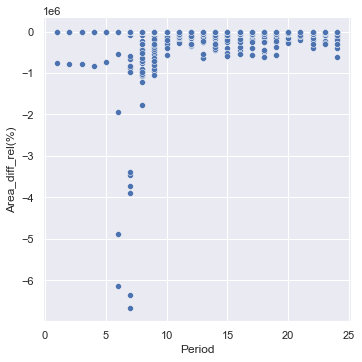

In [285]:
sns.relplot(data=df_TEST_pred_rf_grid_summary, x='Period', y='Area_diff_rel(%)')

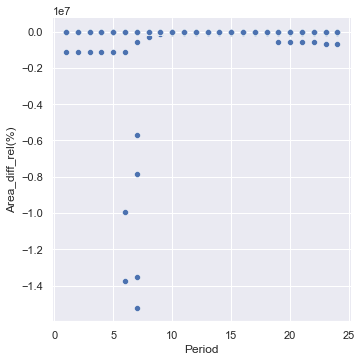

In [286]:
sns.relplot(data=df_TEST_pred_naive_summary, x='Period', y='Area_diff_rel(%)')